# Kernel Density Mapping

Runs in the generic Anaconda environment (not in ArcGIS).

## 1. Load packages

In [82]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
import matplotlib.colors as mcolors
from rasterio.warp import calculate_default_transform, reproject, Resampling
import cartopy.crs as ccrs
from matplotlib.colors import LinearSegmentedColormap
import contextily as cx

## 2. Set parameters

In [83]:
colors = ['blue', 'white', 'red']
n_bins = 100
cmap_name = 'blue_white_red'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)


gis_path = r'E:/Projects/SEACAR_WQ_2024/GIS_Data/'
wb_list = ['BB', 'CH', 'EB', 'GTM']
para_list = ['DO_mgl', 'Sal_ppt', 'Turb_ntu', 'T_c']

## 3. Define function to reproject raster

In [84]:
def reproject_raster(src, dst_crs):
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })
    
    with rasterio.MemoryFile() as memfile:
        with memfile.open(**kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest
                )
        return memfile.open()

### Find min and max values of rasters

In [85]:
min_max_ls = []
for wb in wb_list:
    for i, para in enumerate(para_list):
        geometry = [feature["geometry"] for feature in barrier.__geo_interface__["features"]]
        name = str(wb) + "_" + str(para) + "_kd.tif"
        max_ls = []
        min_ls = []
        with rasterio.open(gis_path + "kde_maps/week/" + name) as src:
            
            # Read the raster data as a numpy array
            raster_data = src.read(1)  # Read the first band
            
            # Calculate max, and min values
            max_ls.append(np.max(raster_data))
            min_ls.append(np.min(raster_data))
        
    min_max_ls.append([min(min_ls),max(max_ls)])

In [86]:
min_max_ls

[[0.0, 0.19786651],
 [-0.4812308, 0.9729131],
 [-0.019493476, 0.78698796],
 [-0.07723754, 10.810852]]

### 4. Generate KDE maps for weekly data

C:\ProgramData\Anaconda3\envs\geo2\Lib\site-packages\matplotlib\image.py:491: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)
C:\ProgramData\Anaconda3\envs\geo2\Lib\site-packages\matplotlib\image.py:491: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)
C:\ProgramData\Anaconda3\envs\geo2\Lib\site-packages\matplotlib\image.py:491: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)
C:\ProgramData\Anaconda3\envs\geo2\Lib\site-packages\matplotlib\image.py:491: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)
C:\ProgramData\Anaconda3\envs\geo2\Lib\site-packages\matplotlib\image.py:491: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)


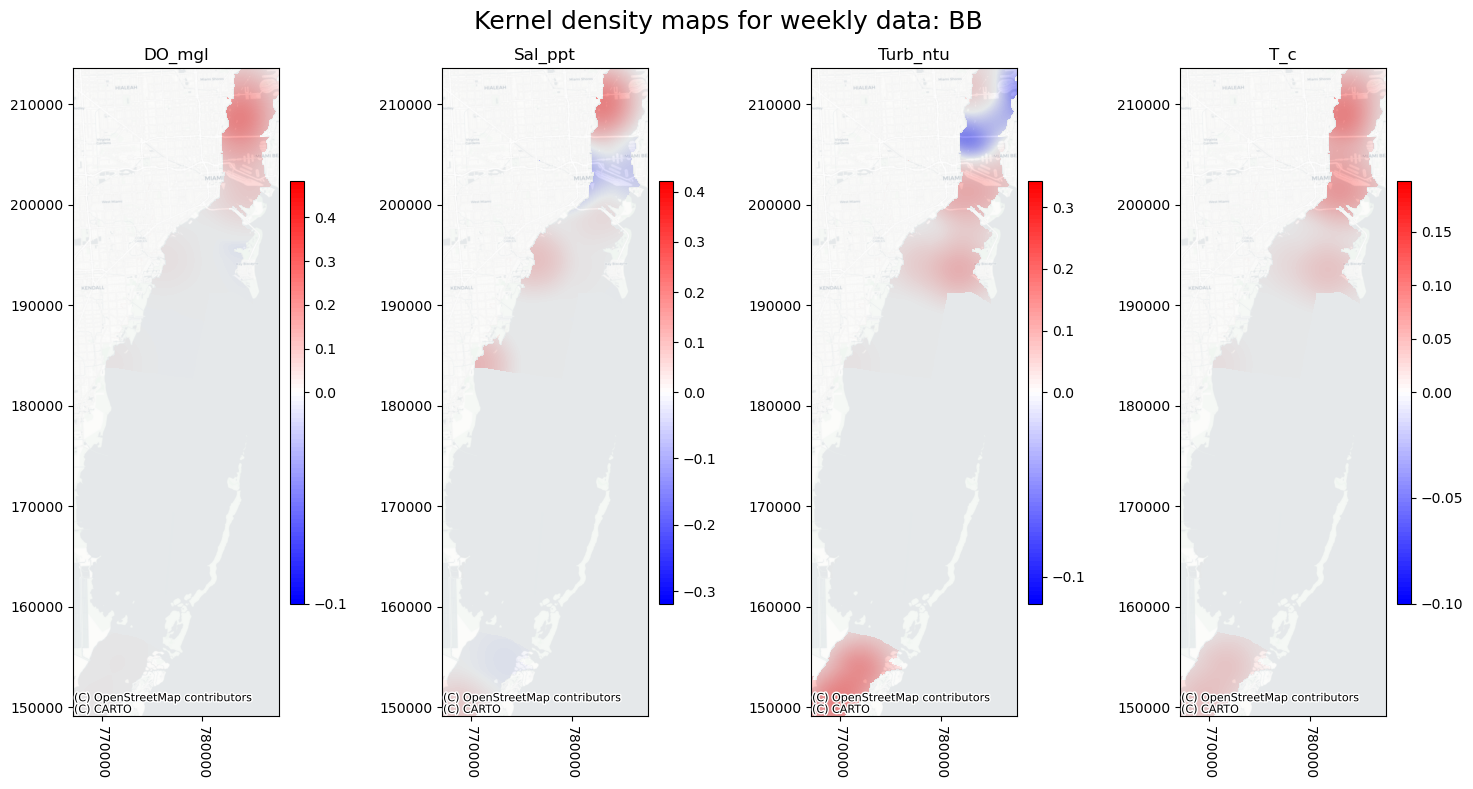

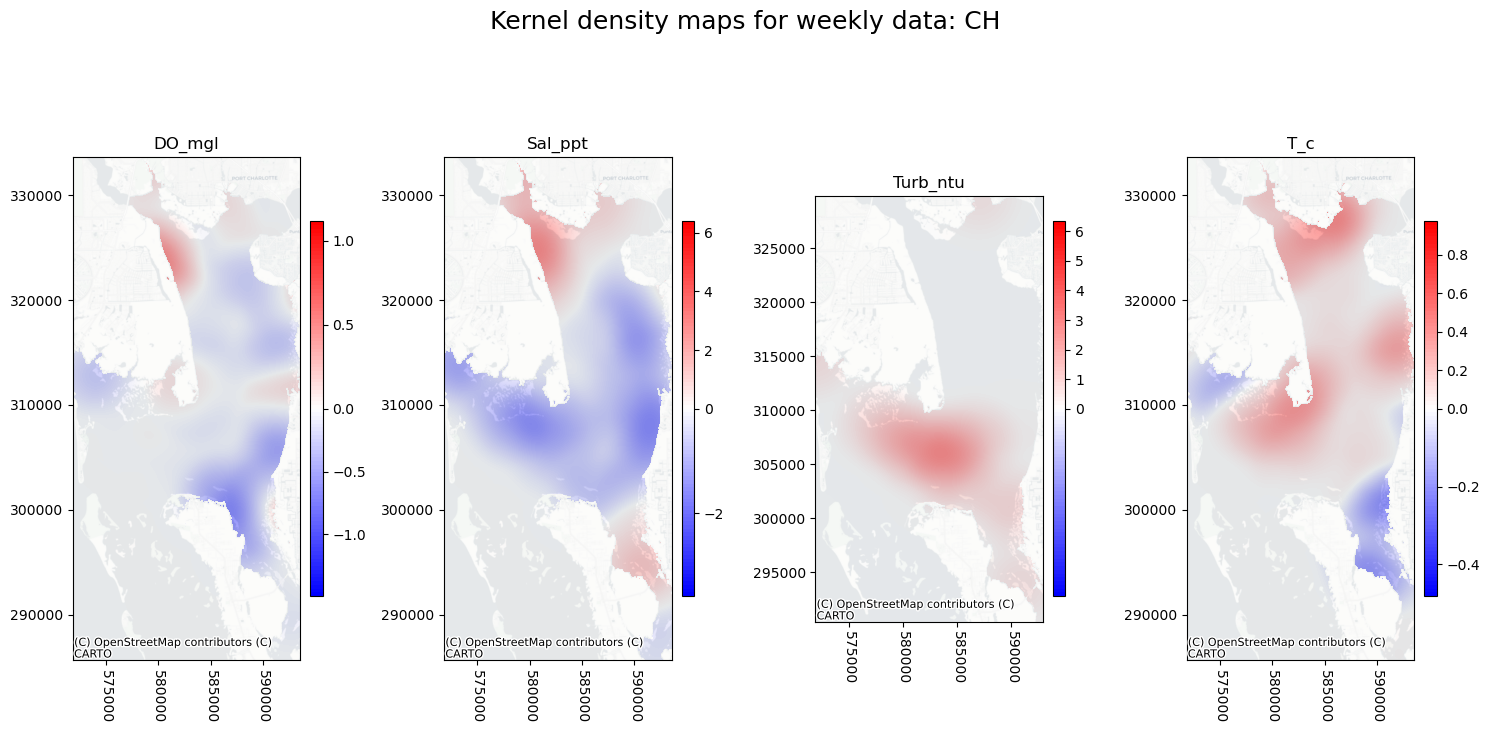

C:\ProgramData\Anaconda3\envs\geo2\Lib\site-packages\matplotlib\image.py:491: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)
C:\ProgramData\Anaconda3\envs\geo2\Lib\site-packages\matplotlib\image.py:491: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)
C:\ProgramData\Anaconda3\envs\geo2\Lib\site-packages\matplotlib\image.py:491: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)
C:\ProgramData\Anaconda3\envs\geo2\Lib\site-packages\matplotlib\image.py:491: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)
C:\ProgramData\Anaconda3\envs\geo2\Lib\site-packages\matplotlib\image.py:491: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)


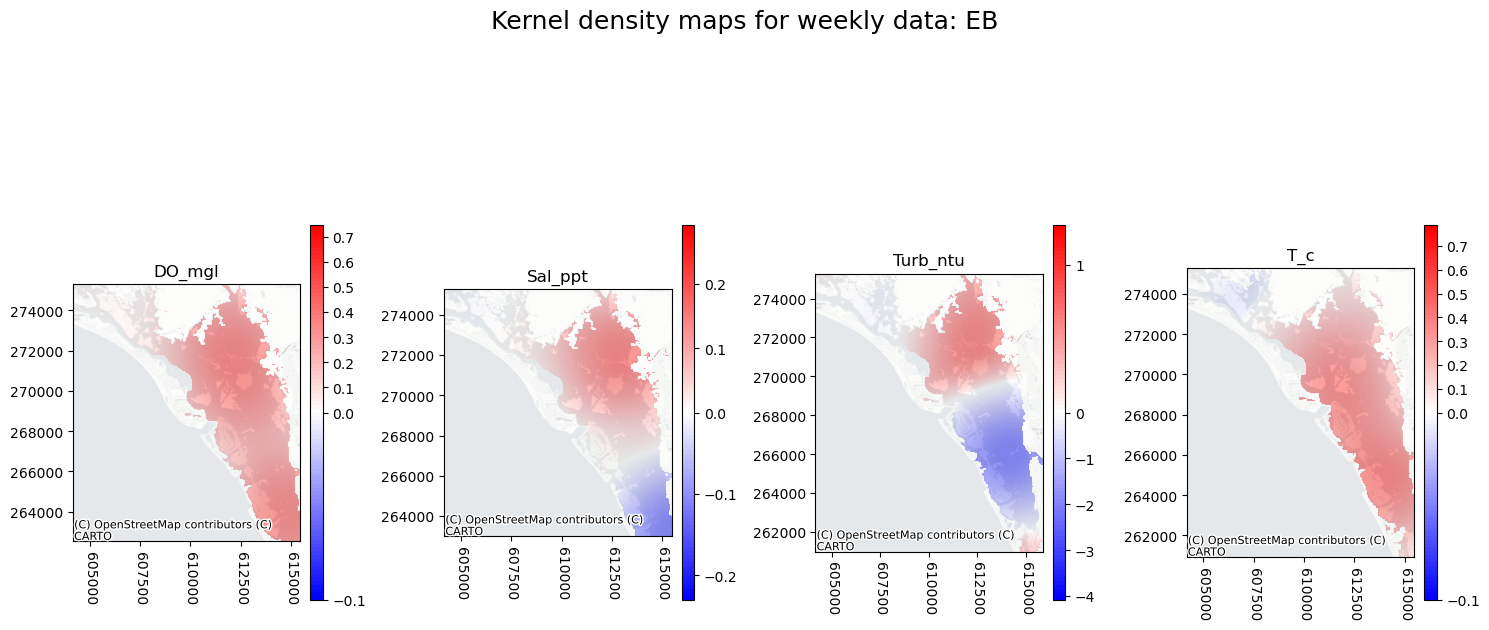

C:\ProgramData\Anaconda3\envs\geo2\Lib\site-packages\matplotlib\image.py:491: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)
C:\ProgramData\Anaconda3\envs\geo2\Lib\site-packages\matplotlib\image.py:491: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)
C:\ProgramData\Anaconda3\envs\geo2\Lib\site-packages\matplotlib\image.py:491: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)


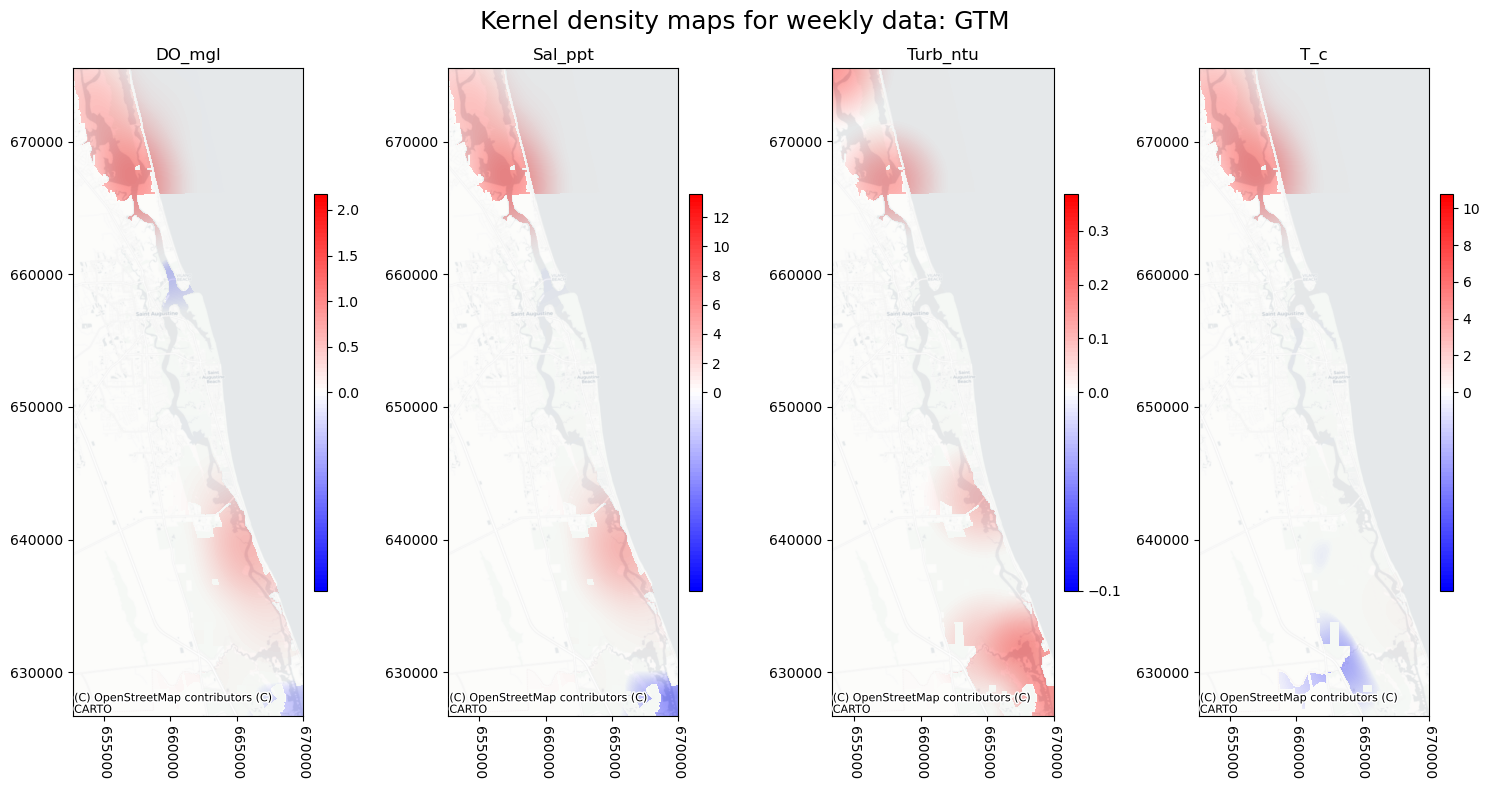

In [93]:
for wb in wb_list:
    fig, axs = plt.subplots(1, 4, figsize=(15, 8))
    fig.suptitle(f'Kernel density maps for weekly data: {wb}',fontsize=18)

    for i, para in enumerate(para_list):
        # ax = axs[i // 2, i % 2]  # Determine subplot position
        ax = axs[i]  # Determine subplot position
        # Read in the shapefile
        barrier = gpd.read_file(gis_path + "managed_area_boundary/" + str(wb) + ".shp",crs="EPSG:3086")
        geometry = [feature["geometry"] for feature in barrier.__geo_interface__["features"]]
        name = str(wb) + "_" + str(para) + "_kd.tif"
        # Open the raster file
        with rasterio.open(gis_path + "kde_maps/week/" + name) as src:
            
            dst_crs = 'EPSG:3086'
            reprojected_src = reproject_raster(src, dst_crs)
            
            out_image, out_transform = mask(reprojected_src, geometry, crop=True)
            out_image = out_image[0]
            out_image = np.ma.masked_equal(out_image, reprojected_src.nodata)
            
            # Read the raster data as a numpy array
            raster_data = src.read(1)  # Read the first band
            max_v = np.max(raster_data)
            min_v = min(- 0.1,np.min(raster_data))
            
            # Normalizer with central value at 0
            norm = mcolors.TwoSlopeNorm(vmin=min_v, vcenter=0, vmax=max_v)
            
            # Plot the image
            im = ax.imshow(out_image, cmap=cm, norm = norm, extent=rasterio.plot.plotting_extent(reprojected_src))
            fig.colorbar(im, ax=ax,fraction=0.05, pad=0.04, aspect=30)
            ax.set_title(f'{para}')

            # Add basemap
            try:
                cx.add_basemap(ax,source=cx.providers.CartoDB.Positron,alpha=0.6, crs="EPSG:3086")
            except Exception as e:
                print(f"Error adding basemap: {e}")
                
            # Set vertical x-axis labels
            ax.xaxis.set_label_position('top')
            for label in ax.get_xticklabels():
                label.set_rotation(270)
    
    plt.tight_layout()
    plt.savefig(gis_path + "kde_maps/"+f'{wb}_w.jpg', dpi=300, format='jpg')
    plt.show()


### 5. Generate KDE maps for monthly data

C:\ProgramData\Anaconda3\envs\geo2\Lib\site-packages\matplotlib\image.py:491: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)
C:\ProgramData\Anaconda3\envs\geo2\Lib\site-packages\matplotlib\image.py:491: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)
C:\ProgramData\Anaconda3\envs\geo2\Lib\site-packages\matplotlib\image.py:491: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)
C:\ProgramData\Anaconda3\envs\geo2\Lib\site-packages\matplotlib\image.py:491: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)
C:\ProgramData\Anaconda3\envs\geo2\Lib\site-packages\matplotlib\image.py:491: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)


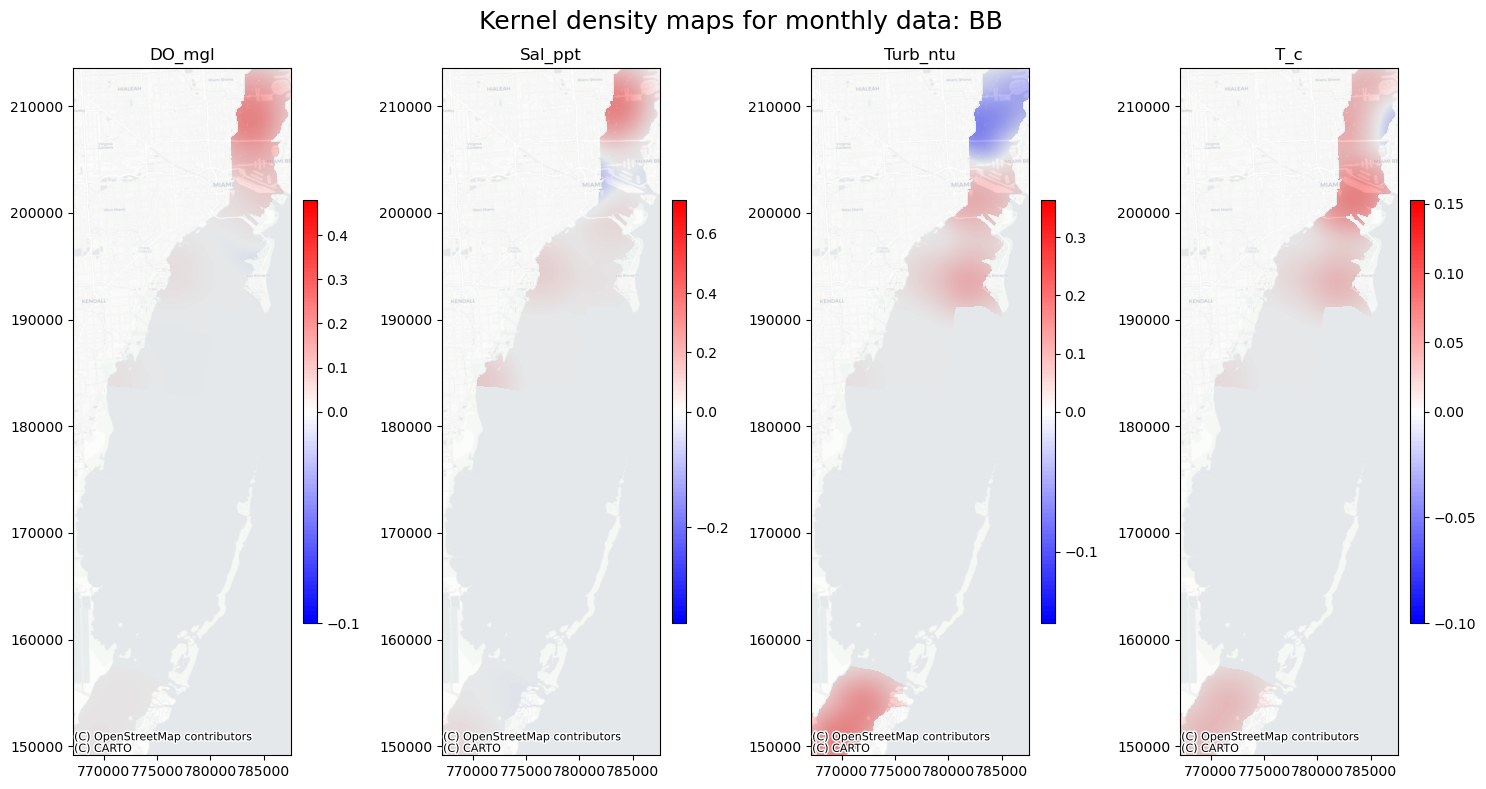

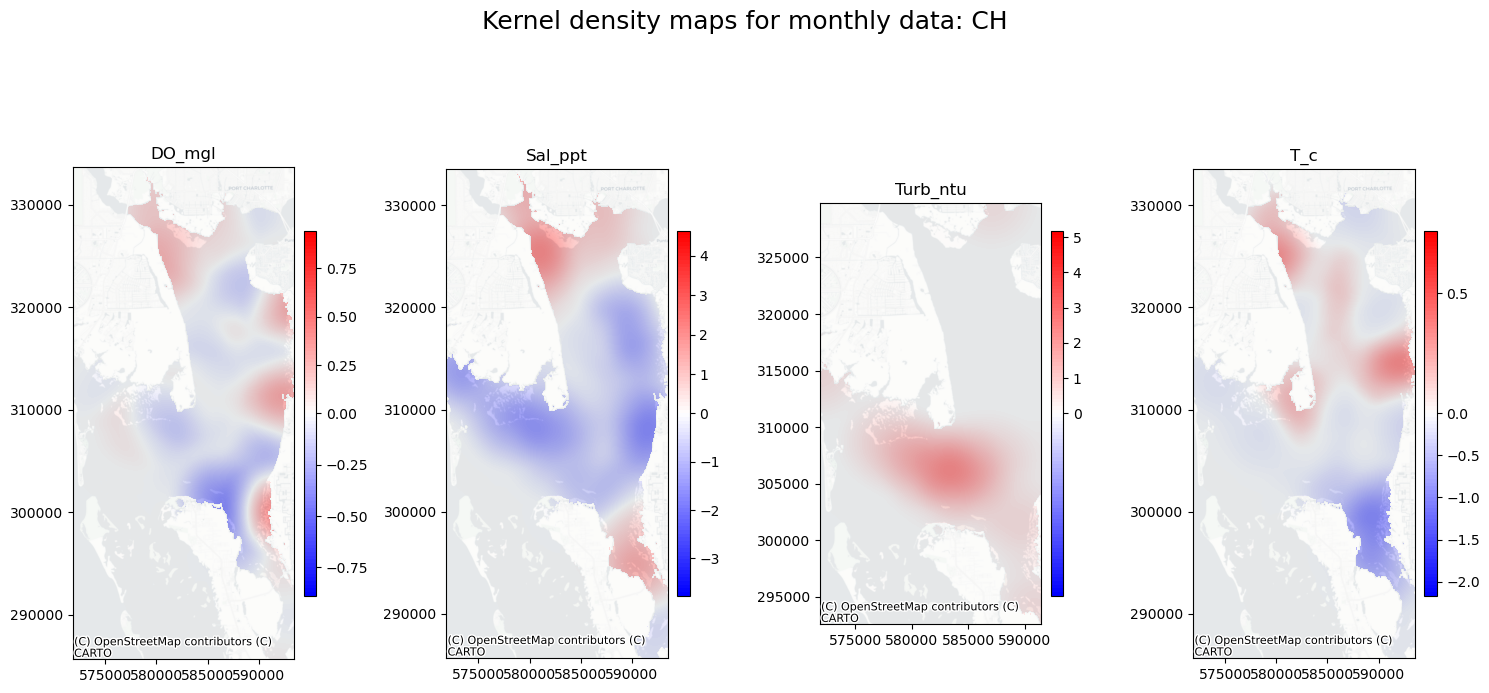

C:\ProgramData\Anaconda3\envs\geo2\Lib\site-packages\matplotlib\image.py:491: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)
C:\ProgramData\Anaconda3\envs\geo2\Lib\site-packages\matplotlib\image.py:491: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)
C:\ProgramData\Anaconda3\envs\geo2\Lib\site-packages\matplotlib\image.py:491: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)
C:\ProgramData\Anaconda3\envs\geo2\Lib\site-packages\matplotlib\image.py:491: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)
C:\ProgramData\Anaconda3\envs\geo2\Lib\site-packages\matplotlib\image.py:491: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)


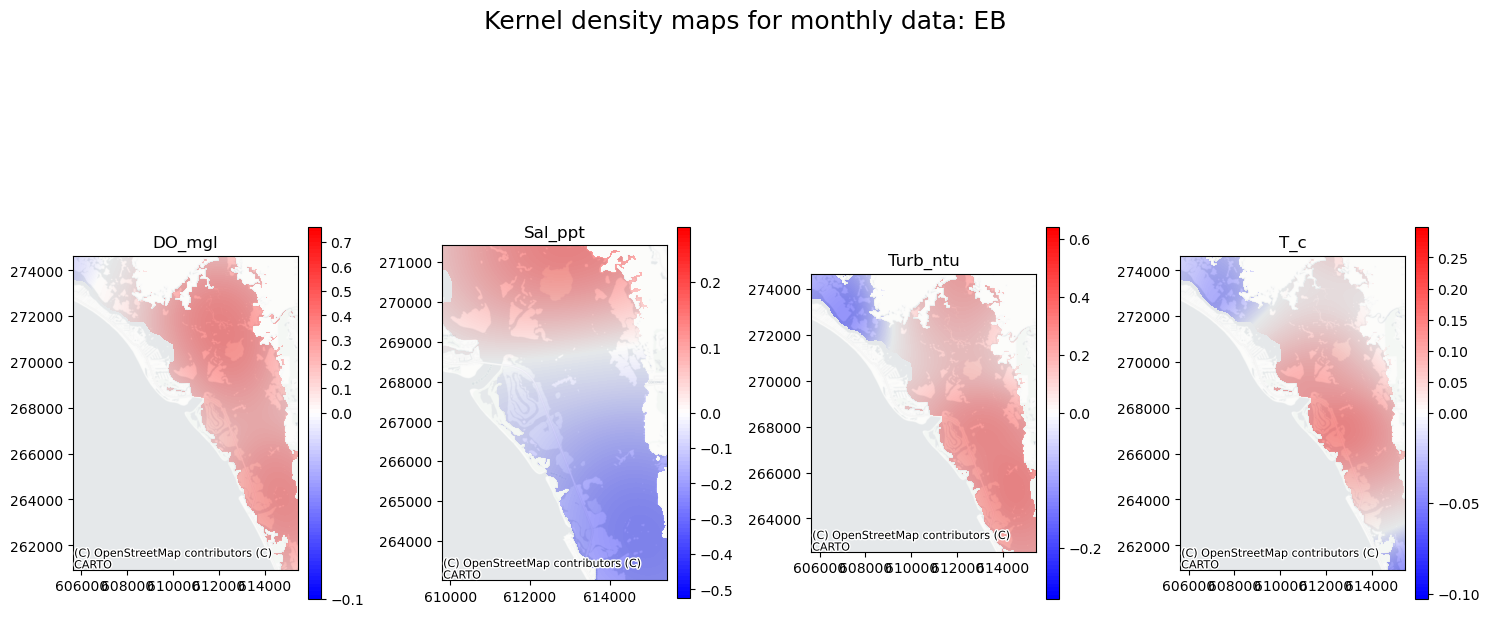

C:\ProgramData\Anaconda3\envs\geo2\Lib\site-packages\matplotlib\image.py:491: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)
C:\ProgramData\Anaconda3\envs\geo2\Lib\site-packages\matplotlib\image.py:491: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)
C:\ProgramData\Anaconda3\envs\geo2\Lib\site-packages\matplotlib\image.py:491: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)


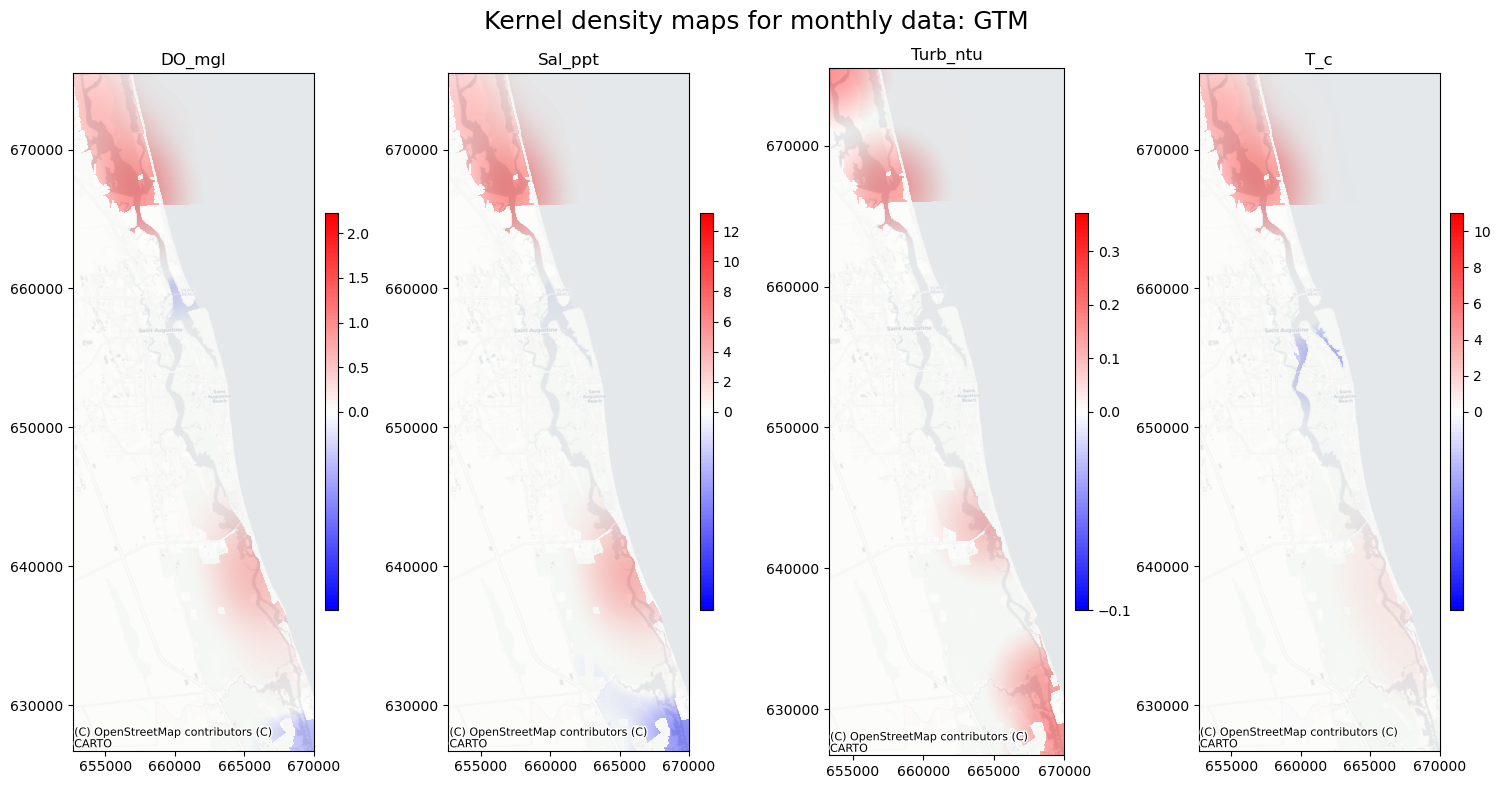

In [90]:
for wb in wb_list:
    fig, axs = plt.subplots(1, 4, figsize=(15, 8))
    fig.suptitle(f'Kernel density maps for monthly data: {wb}', fontsize=18)

    for i, para in enumerate(para_list):
        # ax = axs[i // 2, i % 2]  # Determine subplot position
        ax = axs[i]  # Determine subplot position
        # Read in the shapefile
        barrier = gpd.read_file(gis_path + "managed_area_boundary/" + str(wb) + ".shp",crs="EPSG:3086")
        geometry = [feature["geometry"] for feature in barrier.__geo_interface__["features"]]
        name = str(wb) + "_" + str(para) + "_kd.tif"
        # Open the raster file
        with rasterio.open(gis_path + "kde_maps/month/" + name) as src:
            dst_crs = 'EPSG:3086'
            reprojected_src = reproject_raster(src, dst_crs)
            
            out_image, out_transform = mask(reprojected_src, geometry, crop=True)
            out_image = out_image[0]
            out_image = np.ma.masked_equal(out_image, reprojected_src.nodata)
            
            # Read the raster data as a numpy array
            raster_data = src.read(1)  # Read the first band
            max_v = np.max(raster_data)
            min_v = min(- 0.1,np.min(raster_data))
            
            # Normalizer with central value at 0
            norm = mcolors.TwoSlopeNorm(vmin=min_v, vcenter=0, vmax=max_v)
            
            # Plot the image
            im = ax.imshow(out_image, cmap=cm, norm = norm, extent=rasterio.plot.plotting_extent(reprojected_src))
            fig.colorbar(im, ax=ax,fraction=0.05, pad=0.04, aspect=30)
            ax.set_title(f'{para}')

            # Add basemap
            try:
                cx.add_basemap(ax,source=cx.providers.CartoDB.Positron,alpha=0.6, crs="EPSG:3086")
            except Exception as e:
                print(f"Error adding basemap: {e}")
                
    plt.tight_layout()
    plt.savefig(gis_path + "kde_maps/"+f'{wb}_m.jpg', dpi=300, format='jpg')

    plt.show()